In [1]:
import pandas as pd
import numpy as np

In [2]:
retail = pd.read_csv(r"D:\datasets\online_retail_II.csv")

In [3]:
retail.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


In [4]:
retail.shape

(1067371, 8)

## Data Cleaning

In [5]:
retail.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

- this project is build using RFM ( Recency, Frequency, Monetary).
- description is not important
- Customer Id is most important to calculate RFM

In [6]:
# fill null values in description with unknown product
retail['Description'].fillna('Unknown Product', inplace=True)

C:\Users\vmane\AppData\Local\Temp\ipykernel_20188\4262089.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  retail['Description'].fillna('Unknown Product', inplace=True)


In [7]:
# drop the null values in customer Id
retail = retail.dropna(subset=['Customer ID'])

In [8]:
retail.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [9]:
# remove negative quantity
retail = retail[retail['Quantity'] > 0]

In [10]:
# remove zero or negative price
retail = retail[retail['Price'] > 0]

In [11]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
Index: 805549 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      805549 non-null  object 
 1   StockCode    805549 non-null  object 
 2   Description  805549 non-null  object 
 3   Quantity     805549 non-null  int64  
 4   InvoiceDate  805549 non-null  object 
 5   Price        805549 non-null  float64
 6   Customer ID  805549 non-null  float64
 7   Country      805549 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 55.3+ MB


In [12]:
# create total amount column
retail['Total Amount'] = retail['Quantity'] * retail['Price']

In [13]:
retail.head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total Amount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0


## Create RFM Features
used to summarizes customer purchase behavior.

- RFM - Recency, Frequency, Monetary
- Recency - How Recently a customer made purchases.
- Frequency - How often a customer make purchases.
- Monetary - How much money customer spends.

In [14]:
import datetime as dt

In [15]:
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])

In [16]:
snapshot_date = retail['InvoiceDate'].max() + dt.timedelta(days=1)

In [17]:
rfm = retail.groupby('Customer ID').agg({
    'InvoiceDate' : lambda x: (snapshot_date - x.max()).days,
    'Invoice' : 'nunique',
    'Total Amount': 'sum'
})

In [18]:
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [19]:
rfm.head(10)

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,12,77556.46
12347.0,2,8,5633.32
12348.0,75,5,2019.40
12349.0,19,4,4428.69
12350.0,310,1,334.40
12351.0,375,1,300.93
12352.0,36,10,2849.84
12353.0,204,2,406.76
12354.0,232,1,1079.40


## Feature Scaling
K-means needs scaled data

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
scaler = StandardScaler()

In [22]:
rfm_scaled = scaler.fit_transform(rfm)

In [23]:
rfm_scaled

array([[ 0.59558355,  0.43899789,  5.05805027],
       [-0.95227909,  0.13150188,  0.17743068],
       [-0.60353226, -0.09912012, -0.06780567],
       ...,
       [ 2.19599709, -0.40661612, -0.17586406],
       [ 1.31696398, -0.32974212, -0.11686556],
       [-0.75640758,  0.05462788,  0.079013  ]])

## Elbow Method
used to find optimal number of Clusters.

In [24]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [25]:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters= k, random_state = 42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

In [26]:
sse

[17633.999999999993,
 12532.270124012823,
 7124.406815221328,
 5166.451481284364,
 4517.729347656535,
 3421.486543919322,
 2737.0460037787516,
 2307.201508552175,
 2005.6319635605735,
 1758.1596347186553]

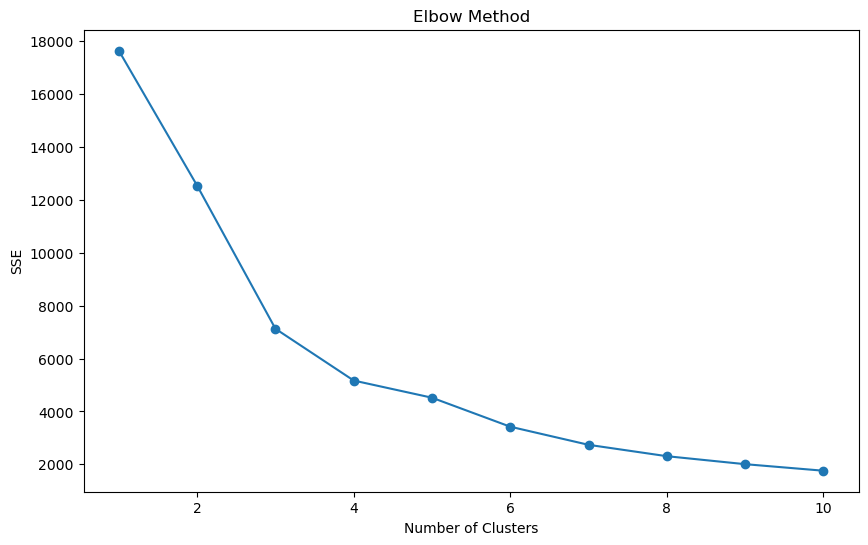

In [27]:
plt.figure(figsize=(10,6))
plt.plot(range(1,11), sse, marker = 'o')
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("Elbow Method")
plt.show()

- from 4 values are mostly stable. so choose k = 4.

## Model Building
- KMeans

In [28]:
kmeans = KMeans(n_clusters= 4, random_state= 42)

In [29]:
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [30]:
rfm.groupby('Cluster').mean()

,Recency,Frequency,Monetary
Cluster,,,
0,463.032032,2.212212,765.244446
1,67.005728,7.307732,3009.402451
2,25.942857,103.714286,83086.079771
3,3.500000,212.500000,436835.792500


In [31]:
import seaborn as sns

<Axes: xlabel='Recency', ylabel='Monetary'>

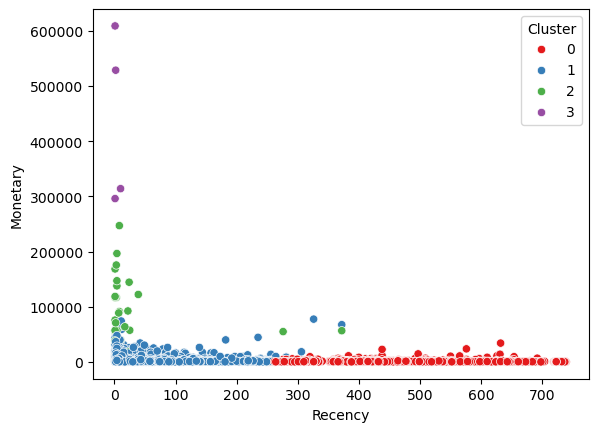

In [32]:
sns.scatterplot(
    x = rfm['Recency'],
    y = rfm['Monetary'],
    hue = rfm['Cluster'],
    palette= 'Set1'
)

- Lower Recency - Most recent purchase --> GOOD.
- Higher Frequency & Monetary - more valuable --> GOOD.

- Cluster 0 : Inactive Customers with minimal engagement and low business value.
  
- Cluster 1 : Regular customers with moderate engagement and growth.

- Cluster 2 : represent loyal, high value customers who contributes significant share of revenue.

- Cluster 3 : Elite customers with exceptional engagement and highest lifetime value.

In [34]:
rfm.reset_index(inplace=True)
rfm.to_excel("Customer segments.xlsx", index=False )